In [4]:
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import urllib.request
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import CSVLogger
from matplotlib import pyplot as plt
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import pathlib
import zipfile

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


### Data

In [7]:
url = "https://nopladi-index.vercel.app/api/raw/?path=/dataset/indonesian_foods_v3.zip"
filename = "../dataset/indonesian_foods.zip"
os.makedirs('../dataset')
urllib.request.urlretrieve(url, filename)

('../dataset/indonesian_foods.zip', <http.client.HTTPMessage at 0x16b44c910>)

In [8]:
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('../dataset/')

In [13]:
from data_preprocessing import IndonesianFoodDataset
data = IndonesianFoodDataset(dataset_path='../dataset/indonesian_foods', split_size=(0.8, 0.1, 0.1))

Directory exists: ../dataset/
ayam_bakar: 919
bakso: 737
bebek_goreng: 472
burger: 728
gado_gado: 764
gudeg: 751
ikan_bakar: 649
martabak_manis: 569
martabak_telor: 598
nasi_goreng: 606
omelette: 727
pempek: 575
rendang: 782
sate: 1129
sayur_asem: 597
semur_jengkol: 550


In [14]:
train_set, val_set, test_set = data.load_data(target_size=(299,299),
                                    rotation_range = 35,
                                    width_shift_range = 0.25,
                                    height_shift_range = 0.25,
                                    shear_range = 0.25,
                                    zoom_range = 0.15,
                                    brightness_range=[0.7, 1.2],
                                    horizontal_flip = True,
                                    # vertical_flip = True,
                                    batch_size = 32)

Copying files: 11153 files [00:05, 2026.15 files/s]


Found 8812 images belonging to 16 classes.
Found 1095 images belonging to 16 classes.
Found 1120 images belonging to 16 classes.


### InceptionV3

In [15]:
pre_trained_model = InceptionV3(input_shape = (299, 299, 3),
                                include_top = False,
                                weights = 'imagenet',
                                pooling = 'max'
                                )

### Freeze Layers

In [16]:
tf.random.set_seed(24)

In [17]:
for layer in pre_trained_model.layers:
  layer.trainable = True

In [18]:
for layer in pre_trained_model.layers:
  if layer.name == 'conv2d_64':
    break
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

### Model

In [19]:
pre_output = pre_trained_model.get_layer('activation_60').output

x = tf.keras.layers.GlobalAveragePooling2D()(pre_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(16, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input, x)

In [20]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0002),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0

### Callbacks

In [ ]:
checkpoint_path = "../trained model/keras_model.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='accuracy')

In [ ]:
class Callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] > 0.95 and logs['val_accuracy'] > 95:
            print("\nAccuracy reached 93% and validation acccuracy reached 90%! Stopping training.")
            self.model.stop_training = False

stop_callback = Callbacks()

In [ ]:
csv_logger = CSVLogger('../history_log/training_log.csv', separator=',', append=False)

### Training Model

In [ ]:
history = model.fit(train_set,
                    callbacks=[checkpoint_callback, csv_logger, stop_callback],
                    validation_data=val_set,
                    epochs = 30)

Epoch 1/30
276/276 [==============================] - ETA: 0s - loss: 2.0550 - accuracy: 0.4114

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


276/276 [==============================] - 383s 1s/step - loss: 2.0550 - accuracy: 0.4114 - val_loss: 2.1567 - val_accuracy: 0.6630
Epoch 2/30
276/276 [==============================] - 372s 1s/step - loss: 1.2102 - accuracy: 0.6966 - val_loss: 0.9272 - val_accuracy: 0.8091
Epoch 3/30
276/276 [==============================] - 372s 1s/step - loss: 0.9314 - accuracy: 0.7734 - val_loss: 0.6368 - val_accuracy: 0.8594
Epoch 4/30
276/276 [==============================] - 352s 1s/step - loss: 0.7836 - accuracy: 0.8124 - val_loss: 0.5621 - val_accuracy: 0.8740
Epoch 5/30
276/276 [==============================] - 365s 1s/step - loss: 0.6894 - accuracy: 0.8352 - val_loss: 0.5038 - val_accuracy: 0.8795
Epoch 6/30
276/276 [==============================] - 361s 1s/step - loss: 0.6145 - accuracy: 0.8525 - val_loss: 0.4717 - val_accuracy: 0.8950
Epoch 7/30
276/276 [==============================] - 360s 1s/step - loss: 0.5597 - accuracy: 0.8572 - val_loss: 0.4752 - val_accuracy: 0.8813
Epoch 8/30

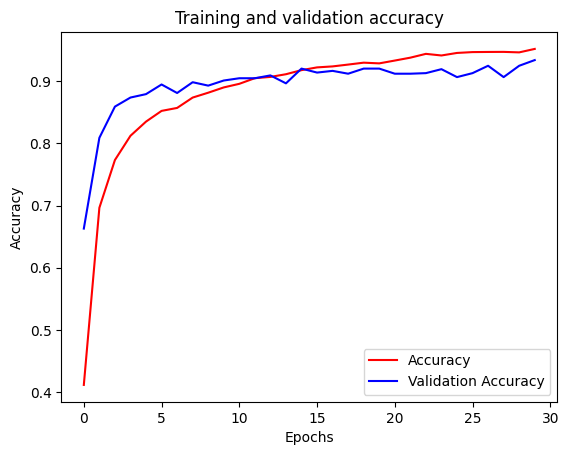

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = [*range(len(acc))]

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


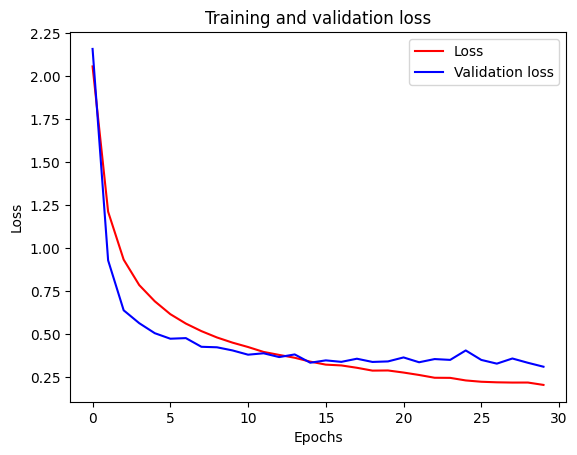

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(len(loss))]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation loss"])
plt.show()

### Testing and Evaluating Model

In [ ]:
class_labels = [
                  "Ayam Bakar", "Bakso", "Bebek Goreng", "Burger",
                  "Gado-Gado", "Gudeg", "ikan bakar","martabak manis","martabak_telor",
                  "nasi goreng","Omelette", "pempek", "Rendang",
                  "Sate", "Sayur Asem", "Semur Jengkol"
                ]

In [ ]:
images, labels = test_set.next()
rand_images = images[np.random.randint(0, len(images), 100)]
predictions = model.predict(rand_images)

4/4 [==============================] - 24s 5s/step


In [ ]:
model.evaluate(test_set)

35/35 [==============================] - 277s 8s/step - loss: 0.2753 - accuracy: 0.9304


[0.27534088492393494, 0.9303571581840515]

1/1 [==============================] - 0s 360ms/step


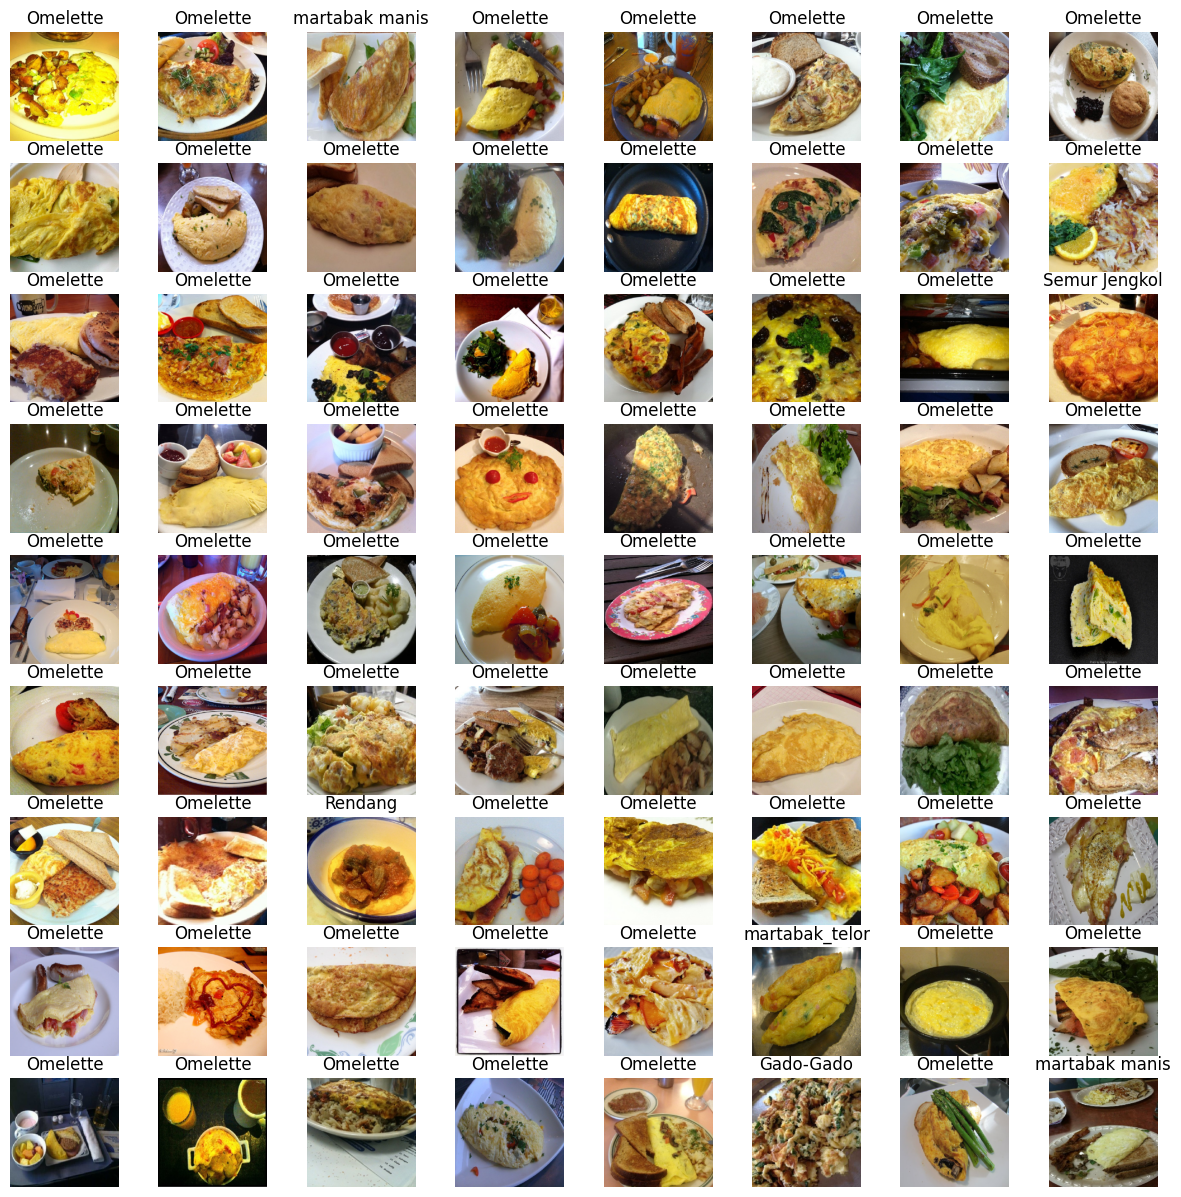

Total Prediksi: 72
Ikan: 66
Bukan Ikan: 6


In [ ]:
files = os.listdir('/content/tmp_set/test/omelette')

rows = int(len(files) / 8 )
columns = 8
fig, rows = plt.subplots(nrows=rows, ncols=columns ,figsize=(15,15))
rows = rows.flatten()


total = 0
not_fish = 0
fish = 0
for i,row in enumerate(rows):
  try:
    img_path = os.path.join('/content/tmp_set/test/omelette', files[i])
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    predictions = model.predict(img_array)
    predictions = np.argmax(predictions)
    prediction_index = np.argmax(model.predict(img_array))
    prediction = class_labels[prediction_index]
    row.imshow(img)
    row.set_title(f"{prediction}")
    row.axis('off')

    total += 1
    if prediction == 'Omelette':
      fish += 1
    else:
      not_fish += 1
  except:
    continue
plt.show()

print("Total Prediksi: {}".format(total))
print("Ikan: {}".format(fish))
print("Bukan Ikan: {}".format(not_fish))

### Saving Model and Convert It into TFLite

In [ ]:
export_dir = './SavedModel'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/drive/MyDrive/intan/saved/model.tflite')
tflite_model_file.write_bytes(tflite_model)